In [1]:
target = 'home_ownership'

In [2]:
pwd

'/Users/grizzlystudio/Library/Mobile Documents/com~apple~CloudDocs/Download_ALL_Apple/github/2024-NT-Python-and-PowerBI/dev'

In [3]:
! ls -l ../data/

total 2265936
-rw-r--r--  1 grizzlystudio  staff  1160157683 Mar 23  2023 LoanStats_web.csv


In [4]:
! head -10 ../data/*.csv

"id","member_id","loan_amnt","funded_amnt","funded_amnt_inv","term","int_rate","installment","grade","sub_grade","emp_title","emp_length","home_ownership","annual_inc","verification_status","issue_d","loan_status","pymnt_plan","url","desc","purpose","title","zip_code","addr_state","dti","delinq_2yrs","earliest_cr_line","inq_last_6mths","mths_since_last_delinq","mths_since_last_record","open_acc","pub_rec","revol_bal","revol_util","total_acc","initial_list_status","out_prncp","out_prncp_inv","total_pymnt","total_pymnt_inv","total_rec_prncp","total_rec_int","total_rec_late_fee","recoveries","collection_recovery_fee","last_pymnt_d","last_pymnt_amnt","next_pymnt_d","last_credit_pull_d","collections_12_mths_ex_med","mths_since_last_major_derog","policy_code","application_type","annual_inc_joint","dti_joint","verification_status_joint","acc_now_delinq","tot_coll_amt","tot_cur_bal","open_acc_6m","open_act_il","open_il_12m","open_il_24m","mths_since_rcnt_il","total_bal_il","il_util","open_rv_1

In [5]:
### https://chat.openai.com/share/d835f292-f1f2-4eeb-85c5-6e437210298e

import pandas as pd

# Assuming `data.csv` is your file name
df = pd.read_csv('../data/LoanStats_web.csv', dtype=str)

In [6]:
# Calculate the percentage of missing values for each column
missing_percentage = df.isnull().mean() * 100

# Filter out columns where more than 30% of the data is missing
columns_to_keep = missing_percentage[missing_percentage <= 30].index.tolist()
filtered_df = df[columns_to_keep]

# If you need to check the resulting DataFrame or save it to a new file
print(filtered_df.head())  # To display the first few rows of the filtered DataFrame
### filtered_df.to_csv('filtered_loanstats_web.csv', index=False)  # To save the filtered DataFrame to a new CSV file

  loan_amnt funded_amnt funded_amnt_inv        term int_rate installment  \
0     12800       12800           12800   36 months   11.99%      425.09   
1      9000        9000            9000   36 months   15.31%      313.36   
2      8000        8000            8000   36 months   10.75%      260.97   
3     25000       25000           25000   60 months   12.99%       568.7   
4     35000       35000           35000   60 months   18.25%      893.54   

  grade sub_grade              emp_title emp_length  ... pct_tl_nvr_dlq  \
0     C        C1  LOGISTICS COORDINATOR    6 years  ...            100   
1     C        C5  Senior Case Assistant    9 years  ...           92.3   
2     B        B4                     Vp    5 years  ...            100   
3     C        C2         Administration  10+ years  ...            100   
4     D        D3           Electrician   10+ years  ...            100   

  percent_bc_gt_75 pub_rec_bankruptcies tax_liens tot_hi_cred_lim  \
0              100     

In [7]:
df = filtered_df

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1432466 entries, 0 to 1432465
Data columns (total 100 columns):
 #   Column                      Non-Null Count    Dtype 
---  ------                      --------------    ----- 
 0   loan_amnt                   1432440 non-null  object
 1   funded_amnt                 1432440 non-null  object
 2   funded_amnt_inv             1432440 non-null  object
 3   term                        1432440 non-null  object
 4   int_rate                    1432440 non-null  object
 5   installment                 1432440 non-null  object
 6   grade                       1432440 non-null  object
 7   sub_grade                   1432440 non-null  object
 8   emp_title                   1302202 non-null  object
 9   emp_length                  1323970 non-null  object
 10  home_ownership              1432440 non-null  object
 11  annual_inc                  1432440 non-null  object
 12  verification_status         1432440 non-null  object
 13  issue_d    

### คำถาม: ในข้อมูลนี้เป็นลูกค้าที่ได้รับเงินกู้ทั้งหมด อยากทราบว่า การระบุ title หรือ ไม่ระบุ มีความสัมพันธ์กับจำนวนเงินกู้หรือไม่ มากน้อยแค่ไหน

In [9]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal
from scikit_posthocs import posthoc_dunn
from scipy import stats

# สมมติว่า df_clean เป็น DataFrame ที่คุณมีอยู่และ 'target' เป็นคอลัมน์ที่มีค่า categorical 3 ค่า
# สร้างสำเนาเพื่อหลีกเลี่ยง SettingWithCopyWarning
df_clean = df.copy()

# แปลงข้อมูลใน 'loan_amnt' ให้เป็นตัวเลข
df_clean['loan_amnt'] = pd.to_numeric(df_clean['loan_amnt'], errors='coerce')

# ตรวจสอบและลบค่า NaN หลังจากการแปลง
df_clean = df_clean.dropna(subset=['loan_amnt'])

# หลังจากแปลงข้อมูลแล้ว สร้าง groups ใหม่และทำการทดสอบอีกครั้ง
groups = [df_clean[df_clean[target] == value]['loan_amnt'] for value in df_clean[target].unique()]

# ลบ Series ที่ว่างเปล่า (ถ้ามี)
groups = [group for group in groups if not group.empty]

In [10]:
# ตัวอย่างการทำการทดสอบ Kolmogorov-Smirnov และ Anderson-Darling สำหรับกลุ่มข้อมูลแรก
data = groups[0]  # ใช้ข้อมูลกลุ่มแรกเป็นตัวอย่าง

# ทดสอบ Kolmogorov-Smirnov
ks_stat, ks_p = stats.kstest(data, 'norm', args=(data.mean(), data.std()))
print(f'Kolmogorov-Smirnov Test: stat={ks_stat:.3f}, p={ks_p:.3f}')

# ทดสอบ Anderson-Darling
ad_statistic, critical_values, significance_levels = stats.anderson(data, dist='norm')
print(f'Anderson-Darling Test: statistic={ad_statistic:.3f}')
for i in range(len(critical_values)):
    print(f'Critical Value (at {significance_levels[i]}%): {critical_values[i]:.3f},',
          'Data looks normal' if ad_statistic < critical_values[i] else 'Data does not look normal')

# ต่อไปคุณอาจต้องการทำการทดสอบ Post-hoc ถ้า Kruskal-Wallis H-test ของคุณแสดงความแตกต่างที่มีนัยสำคัญ
# stat, p = kruskal(*groups)
# ถ้า p < 0.05, ต้องการทำ posthoc test
# p_values_matrix = posthoc_dunn(groups, p_adjust='bonferroni')
# print(p_values_matrix)


Kolmogorov-Smirnov Test: stat=0.107, p=0.000
Anderson-Darling Test: statistic=11683.456
Critical Value (at 15.0%): 0.576, Data does not look normal
Critical Value (at 10.0%): 0.656, Data does not look normal
Critical Value (at 5.0%): 0.787, Data does not look normal
Critical Value (at 2.5%): 0.918, Data does not look normal
Critical Value (at 1.0%): 1.092, Data does not look normal


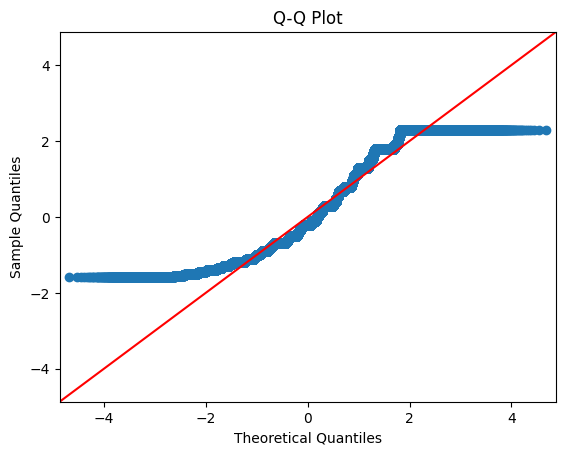

In [11]:
import numpy as np 
import statsmodels.api as sm 
import matplotlib.pyplot as plt 

# สมมติว่า 'data' เป็นชุดข้อมูลที่คุณต้องการตรวจสอบ
# ตัวอย่าง: data = df_clean[df_clean['target'] == 'Group1']['loan_amnt']

# เลือกข้อมูลจากหนึ่งในกลุ่มของคุณ
data = groups[0]  # เปลี่ยน 0 เป็น index ของกลุ่มที่คุณต้องการตรวจสอบ

# สร้าง Q-Q plot
sm.qqplot(data, line ='45', fit=True) 
plt.title('Q-Q Plot')
plt.show()


In [12]:
# ทำ Kruskal-Wallis H-test อีกครั้ง
stat, p = kruskal(*groups)
print(f'Kruskal-Wallis H-test stat={stat:.3f}, p={p:.3e}')

# การแปรผล
alpha = 0.05  # ระดับนัยสำคัญ
if p < alpha:
    print("มีความแตกต่างที่มีนัยสำคัญทางสถิติระหว่างกลุ่ม (reject H0)")
    # ทำ Post-hoc test ถ้าจำเป็น
    # ...
else:
    print("ไม่มีความแตกต่างที่มีนัยสำคัญทางสถิติระหว่างกลุ่ม (fail to reject H0)")

Kruskal-Wallis H-test stat=41438.492, p=0.000e+00
มีความแตกต่างที่มีนัยสำคัญทางสถิติระหว่างกลุ่ม (reject H0)


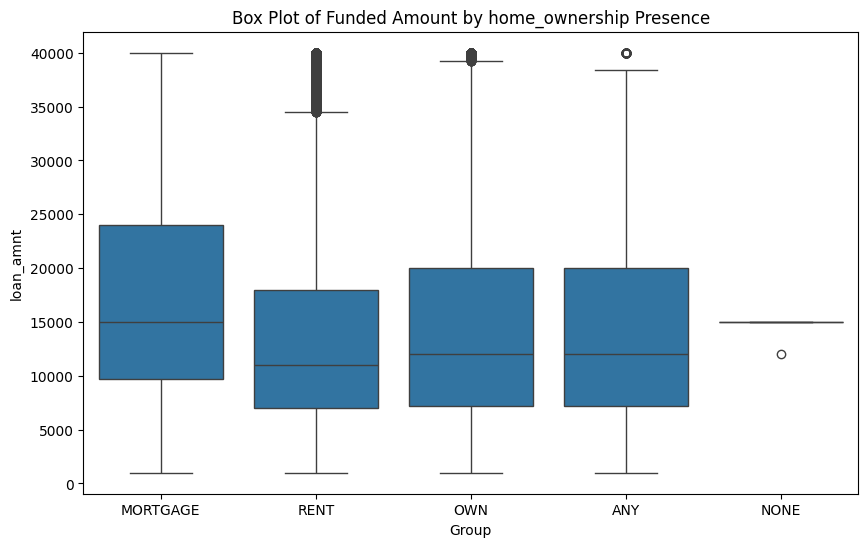

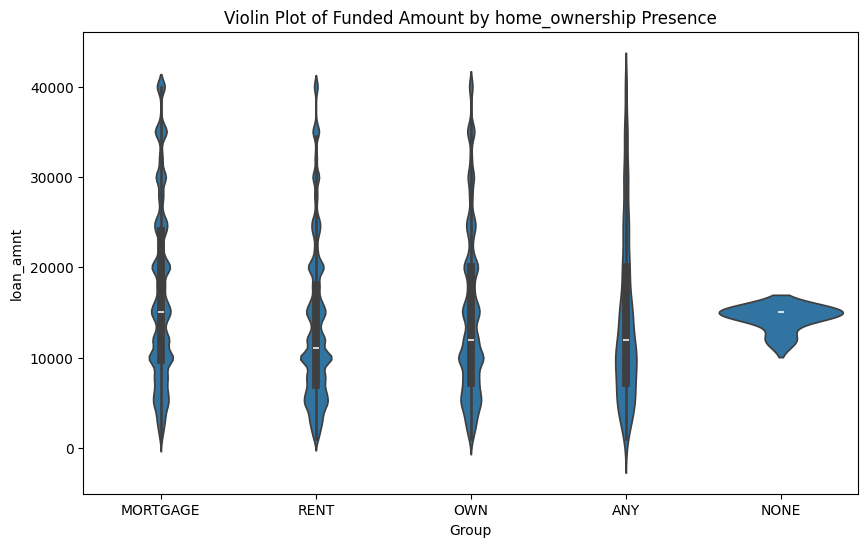

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt


# สมมติว่า 'target' เป็นตัวแปร categorical ที่มีค่าเป็น 'A', 'B', 'C' ฯลฯ
# คุณจะต้องกำหนดกลุ่มข้อมูลโดยใช้ตัวแปร 'target' ใน 'df_clean'
# ตัวอย่าง: การสร้าง plot_data สำหรับ 'target' แบ่งเป็นกลุ่ม A, B, C, ...

plot_data = pd.DataFrame({
    'loan_amnt': df_clean['loan_amnt'],
    'Group': df_clean[target]
})

# จากนั้นสร้าง Box Plot และ Violin Plot ตามโค้ดข้างบน


# Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Group', y='loan_amnt', data=plot_data)
plt.title(f'Box Plot of Funded Amount by {target} Presence')
plt.show()

# Violin Plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Group', y='loan_amnt', data=plot_data)
plt.title(f'Violin Plot of Funded Amount by {target} Presence')
plt.show()

In [14]:
df[[target,'loan_amnt']].describe()

,home_ownership,loan_amnt
count,1432440,1432440
unique,5,1561
top,MORTGAGE,10000
freq,701646,129564


In [15]:
df_clean[[target,'loan_amnt']].describe()

,loan_amnt
count,1.432440e+06
mean,1.537039e+04
std,9.646026e+03
min,1.000000e+03
25%,8.000000e+03
50%,1.300000e+04
75%,2.000000e+04
max,4.000000e+04


In [16]:
df_clean.groupby(target).size()

home_ownership
ANY           2940
MORTGAGE    701646
NONE             5
OWN         170888
RENT        556961
dtype: int64

In [17]:
from scipy import stats

# ข้อมูลของคุณต้องไม่มีค่าที่เป็นลบ
data = groups[0] # เลือกกลุ่มข้อมูลที่ต้องการทำการ transform
data_clean = data[data > 0]  # ตรวจสอบว่าไม่มีค่าที่เป็นลบ

# ทำ Box-Cox Transformation
data_transformed, fitted_lambda = stats.boxcox(data)


Box-Cox Transformation Lambda: 0.40620317456989946


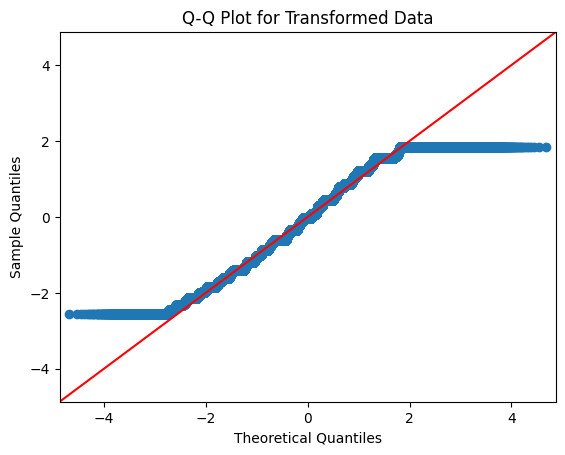

Shapiro-Wilk Test on Transformed Data: stat=0.987, p=0.000


/opt/homebrew/Caskroom/miniforge/base/envs/python3.8/lib/python3.8/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [18]:
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm

# สมมติว่า 'data' คือ Series หรือ array ที่มีข้อมูลของคุณ
##### data = groups[0]  # ใช้กลุ่มข้อมูลแรกเป็นตัวอย่าง

# ก่อนใช้ Box-Cox Transformation คุณต้องตรวจสอบว่าข้อมูลทั้งหมดมีค่ามากกว่า 0
#### data = data[data > 0]

# ทำ Box-Cox Transformation
#### data_transformed, fitted_lambda = stats.boxcox(data)

# แสดงค่า Lambda ที่ใช้ในการ transform
print(f'Box-Cox Transformation Lambda: {fitted_lambda}')

# สร้าง Q-Q plot สำหรับข้อมูลหลังการ transform
sm.qqplot(data_transformed, line='45', fit=True)
plt.title('Q-Q Plot for Transformed Data')
plt.show()

# ตรวจสอบการแจกแจงหลังจากการ transform โดยการทำการทดสอบ Shapiro-Wilk อีกครั้ง
stat, p = stats.shapiro(data_transformed)
print('Shapiro-Wilk Test on Transformed Data: stat=%.3f, p=%.3f' % (stat, p))


In [19]:
from scipy import stats

# สมมติว่า 'data_transformed' คือข้อมูลที่คุณได้ทำการ transform ไว้แล้ว

# ทำการทดสอบ Kolmogorov-Smirnov
ks_stat, ks_p = stats.kstest(data_transformed, 'norm')
print(f'Kolmogorov-Smirnov Test: stat={ks_stat:.3f}, p={ks_p:.3f}')

# ทำการทดสอบ Anderson-Darling
ad_test = stats.anderson(data_transformed, dist='norm')
print(f'Anderson-Darling Test: statistic={ad_test.statistic:.3f}')
for i in range(len(ad_test.critical_values)):
    sl, cv = ad_test.significance_level[i], ad_test.critical_values[i]
    print(f'Critical Value (at {sl}%): {cv:.3f},', 'Data looks normal' if ad_test.statistic < cv else 'Data does not look normal')


Kolmogorov-Smirnov Test: stat=1.000, p=0.000
Anderson-Darling Test: statistic=2479.747
Critical Value (at 15.0%): 0.576, Data does not look normal
Critical Value (at 10.0%): 0.656, Data does not look normal
Critical Value (at 5.0%): 0.787, Data does not look normal
Critical Value (at 2.5%): 0.918, Data does not look normal
Critical Value (at 1.0%): 1.092, Data does not look normal
